Quick notebook to get plots for how much faster ripple is than squeeze

In [65]:
from collections import defaultdict
import os
import sys 
from tqdm import tqdm
import itertools
sys.path.append("/data/jeff-law/projects/fungcat-function-prediction/src")
import utils.file_utils as utils
#sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(__file__)))))
import fungcat_settings as f_settings
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import describe

In [2]:
os.chdir("../..")

In [3]:
os.getcwd()

'/data/jeff-law/projects/fungcat-function-prediction'

In [ ]:
# this was the command I used to generate the results
# source the python environment first
#!source py3env/bin/activate
!python src/algorithms/gain-scipy/run_algs.py --version 2017_10-seq-sim  --exp-name rem-neg-iea-40-50 --pos-neg-file inputs/pos-neg/rem-neg-iea/rem-neg-iea-pos-neg-bp-10-list.tsv --pos-neg-file inputs/pos-neg/rem-neg-iea/rem-neg-iea-pos-neg-mf-10-list.tsv --only-functions inputs/only-functions/rem-neg-iea/rem-neg-iea-40-50.txt -A sinksourceplus-ripple  -A sinksourceplus-squeeze -a 0.8 --forcealg --num-pred-to-write 0 --epsUB 0.01
# I dont' have a command line option yet for running with the submatrix.
# I just comment out the line in sinksource_ripple.py
# I might just fix it to be if the # positives is small enough (< 50 or something)
#!python src/algorithms/gain-scipy/run_algs.py --version 2017_10-seq-sim  --exp-name rem-neg-iea-40-50-full --pos-neg-file inputs/pos-neg/rem-neg-iea/rem-neg-iea-pos-neg-bp-10-list.tsv --pos-neg-file inputs/pos-neg/rem-neg-iea/rem-neg-iea-pos-neg-mf-10-list.tsv --only-functions inputs/only-functions/rem-neg-iea/rem-neg-iea-40-50.txt -A sinksourceplus-ripple  -A sinksourceplus-squeeze -a 0.8 --forcealg --num-pred-to-write 0 --epsUB 0.01

In [77]:
# load the results table
out_dir = "outputs/viz/params-results"
# exp_name = "rem-neg-iea-40-50"
# exp_name = "rem-neg-iea-40-50-full"
exp_name = "rem-neg-iea-10-50-submatrix"
version = "2017_10-seq-sim"
results_file = "%s/%s-%s-params-results.tsv" % (out_dir, exp_name, version)
df = pd.read_csv(results_file, sep='\t')
# sort it by the GO term to make sure the ripple and squeeze comparison is aligned
df = df.sort_values(['goterm', 'alg'])
# also remove goterms with a time of 0
df = df[df.time != 0]
# TODO I need to write more decimal places
df.loc[df['update-time'] == 0, 'update-time'] = 0.0005
print(df.describe())
df.head()

             # pos         # unk             a       k    epsUB         time  \
count  2342.000000   2342.000000  2.342000e+03  2342.0  2342.00  2342.000000   
mean     22.489325  36687.242528  8.000000e-01   200.0     0.01     0.436544   
std      10.366732   2618.916415  2.220920e-16     0.0     0.00     0.331950   
min      10.000000    205.000000  8.000000e-01   200.0     0.01     0.002000   
25%      14.000000  36765.250000  8.000000e-01   200.0     0.01     0.268000   
50%      20.000000  36820.000000  8.000000e-01   200.0     0.01     0.320000   
75%      29.000000  36938.000000  8.000000e-01   200.0     0.01     0.404750   
max      49.000000  37647.000000  8.000000e-01   200.0     0.01     2.570000   

       update-time        iters        # comp         len_N  
count  2342.000000  2342.000000  2.342000e+03   2342.000000  
mean      0.106814    16.490606  6.655107e+07  21114.073442  
std       0.091332     8.510598  5.279462e+07  15723.613683  
min       0.000500     4.000000

,alg,goterm,# pos,# unk,a,k,t,s,eps,epsUB,time,update-time,iters,# comp,len_N
0,sinksourceplus-ripple,GO:0000035,15,36742,0.8,200,2,200,-,0.01,0.159,0.002,8,2170000.0,3000
1270,sinksourceplus-squeeze,GO:0000035,15,36742,0.8,200,-,-,-,0.01,0.328,0.190,24,114000000.0,36742
1,sinksourceplus-ripple,GO:0000036,17,36740,0.8,200,2,200,-,0.01,0.253,0.005,8,5170000.0,5623
1271,sinksourceplus-squeeze,GO:0000036,17,36740,0.8,200,-,-,-,0.01,0.343,0.213,27,128000000.0,36740
2,sinksourceplus-ripple,GO:0000049,33,36835,0.8,200,2,200,-,0.01,0.158,0.002,8,2040000.0,5041


In [98]:
def plot_hist(s, s2=None, out_file=None, title='', xlabel='', ylabel='', xlabel2='', ylabel2=''):
    if s2 is None:    
        fig, ax = plt.subplots()
        s.hist()
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    else:
        fix, (ax1, ax2) = plt.subplots(2, figsize=(6,7))
        s.hist(ax=ax1)
        s2.hist(ax=ax2, bins=30)
        ax1.set_xlabel(xlabel)
        ax1.set_ylabel(ylabel)
        ax2.set_xlabel(xlabel2)
        ax2.set_ylabel(ylabel2)
        
    plt.suptitle(title)
#     plt.tight_layout()
    if out_file is not None:
        print("writing figure to %s" % (out_file))
        plt.savefig(out_file)
    plt.show()
    plt.close()

In [89]:
# plot a histogram of the factor improvement of ss-ripple over ss-squeeze
# comparison = 'update-time'
# col = comparison
comparison = 'num_comp'
col = '# comp'
squeeze_time = df[df['alg'].isin(['sinksourceplus-squeeze'])]['time']
# if there are multiple ripple runs, then groupby the algorithm and take the max
ripple_time = df[df['alg'].isin(['sinksourceplus-ripple'])]['time']
total_factor_improvement = np.asarray(squeeze_time) / np.asarray(ripple_time)
squeeze_time = df[df['alg'].isin(['sinksourceplus-squeeze'])][col]
# if there are multiple ripple runs, then groupby the algorithm and take the max
ripple_time = df[df['alg'].isin(['sinksourceplus-ripple'])][col]
update_factor_improvement = np.asarray(squeeze_time) / np.asarray(ripple_time)
print(total_factor_improvement)
print(update_factor_improvement)
print(describe(total_factor_improvement))
print(describe(update_factor_improvement))


[2.06289308 1.35573123 2.03164557 ... 0.62445415 0.33111702 0.73595506]
[52.53456221 24.7582205  62.74509804 ... 11.06796117  5.25252525
 13.54037267]
DescribeResult(nobs=1171, minmax=(0.08333333333333333, 6.745454545454545), mean=1.0552901795726515, variance=0.9333029262616995, skewness=2.013058152441401, kurtosis=5.655303359544504)
DescribeResult(nobs=1171, minmax=(1.5083333333333333, 3056.3002680965146), mean=54.69815065334711, variance=39642.70452516477, skewness=8.584458201233565, kurtosis=87.9581812166626)


writing figure to outputs/viz/params-results/rem-neg-iea-10-50-submatrix-2017_10-seq-sim-factor-improvement-num_comp.pdf


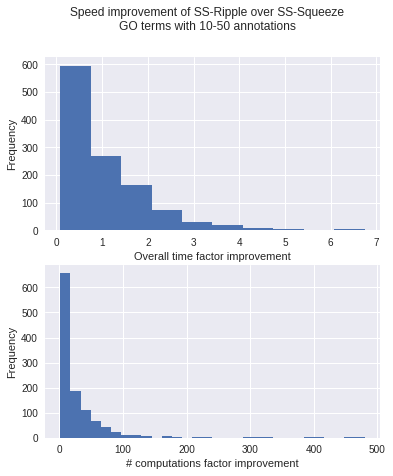

In [101]:
out_file = "%s/%s-%s-factor-improvement-%s.pdf" % (out_dir, exp_name, version, comparison)
s = pd.Series(update_factor_improvement)
s = s[s < 500]
plot_hist(pd.Series(total_factor_improvement), s, 
          out_file=out_file, title='Speed improvement of SS-Ripple over SS-Squeeze\nGO terms with 10-50 annotations',
          xlabel='Overall time factor improvement', xlabel2='# computations factor improvement',
#           xlabel='Overall time factor improvement', xlabel2='%s factor improvement' % (col),
          ylabel='Frequency', ylabel2='Frequency')